In [1]:
import wandb
import datetime
import itertools as it

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from matplotlib import cm as cm

api = wandb.Api()
#run = api.run(f"marauders/TFC_pre-training/kkq3pnzk")


In [55]:
def plot_results(data1, data2, data3, data4):

    # Define subplot sizes
    # print("shape of 0: ", data1.shape)
    # print("shape of 1: ", data2.shape)
    # print("shape of 2: ", data3.shape)
    # print("shape of 3: ", data4.shape)

    subplot_sizes = [(1, 4), (4, 4), (1, 4), (1, 1)]  # (height, width) for each subplot

    # Create a figure and subplots with specified sizes
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [size[0] for size in subplot_sizes]})

    # Combine data from all plots to find common vmin and vmax
    all_data = np.concatenate([data1.flatten(), data2.flatten(), data3.flatten(), data4.flatten()])
    vmin = np.min(all_data)
    vmax = np.max(all_data)

    # Just the upper triangle for data2
    mask =  np.tri(data2.shape[0], k=0)
    data2 = np.ma.array(data2, mask=mask) # mask out the lower triangle
    # cmap = cm.get_cmap('jet', 10) # jet doesn't have white color
    # cmap.set_bad('w') # default value is 'k'

    # Plot heat maps with adjusted aspect ratio
    im1 = axes[0].imshow(data1, cmap = 'hot', norm = "linear", interpolation = 'nearest', aspect = "auto", vmin = vmin, vmax = vmax)
    im2 = axes[1].imshow(data2, cmap = 'hot', norm = "linear", interpolation = 'nearest', aspect = "auto", vmin = vmin, vmax = vmax)
    im3 = axes[2].imshow(data3, cmap = 'hot', norm = "linear", interpolation = 'nearest', aspect = "auto", vmin = vmin, vmax = vmax)
    im4 = axes[3].imshow(data4, cmap = 'hot', norm = "linear", interpolation = 'nearest', aspect = 'equal', vmin = vmin, vmax = vmax)

    # Labels for plots, using A, B, C, D for simplicity
    axes[0].set_xticks(np.arange(4))  # Set x ticks
    axes[0].set_xticklabels(["S", "F", "H", "E"], fontsize = 14)  # Set x tick labels
    axes[0].yaxis.set_ticks([])
    axes[0].set_yticklabels([])

    axes[1].set_xticks(np.arange(4))  # Set x ticks
    axes[1].set_xticklabels(["S", "F", "H", "E"], fontsize = 14)  # Set x tick labels
    axes[1].set_yticks(np.arange(4))  # Set x ticks
    axes[1].set_yticklabels(["S", "F", "H", "E"], fontsize = 14)  # Set y tick labels

    axes[2].set_xticks(np.arange(4))  # Set x ticks
    axes[2].set_xticklabels(["SFH", "SFE", "SHE", "FHE"], fontsize = 14)  # Set x tick labels
    axes[2].yaxis.set_ticks([])
    axes[2].set_yticklabels([])

    axes[3].set_xticks(np.arange(1))  # Set x ticks
    axes[3].set_xticklabels(["SFHE"], fontsize = 14)  # Set x tick labels
    axes[3].yaxis.set_ticks([])
    axes[3].set_yticklabels([])
    # axes[0].set_yticks(np.arange(len(data)))  # Set y ticks
    # axes[0].set_yticklabels(np.arange(1, len(data) + 1))  # Set y tick labels
    
    # Set the title for figure
    fig.suptitle("The heatmap of training on different pre_train dataset setups and finetuning on Epilepsy", fontsize = 16 )

    # Add the explanation text for the dataset abbreviation
    plt.text(0.5, 0.02,  'S = SleepEEG; F = FD_A; H = HAR; E = ECG', fontsize = 14, horizontalalignment='center', verticalalignment='center', transform=plt.gcf().transFigure)
    
    # Adjust space between subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    # Add colorbar
    cb = plt.colorbar(im2, ax = axes, orientation = 'vertical')
    cb.ax.tick_params(labelsize = 14)
    # Adjust layout
    # plt.tight_layout()

    # Show plot
    plt.show()

In [8]:
def get_experiments(datasets, dt = datetime.datetime(2024,5,12)):
    filters = {
        "summary_metrics.pre_train_dataset" : datasets,             # Datasets to collect
        "summary_metrics.mode": "fine_tune_test",                   # During fine_tune_test
        "summary_metrics._timestamp" : {"$gte" : dt.timestamp()} }  # The run was created after
    
    runs = api.runs(path = "marauders/TFC_pre-training", filters = filters) 

    return runs

In [9]:
def get_avg_auc(runs):
    avg_auc = []
    for run in runs:
        curr_auc = run.summary['test/metrics/total_auc']
        avg_auc.append(curr_auc)

    if len(avg_auc): 
        return sum(avg_auc)/len(avg_auc)
    else: return 0

In [17]:
def experiment():
    datasets = ["SleepEEG", "FD_A", "HAR", "ECG"]

    single_dataset_runs = [get_experiments([ds]) for ds in datasets]
    double_dataset_runs = [get_experiments(pair) for pair in it.product(datasets, datasets)]
    triple_dataset_runs = [get_experiments(triplet) for triplet in it.combinations(datasets, 3)]
    all_dataset_runs    = [get_experiments(datasets)]

    single_dataset_auc = np.array( [get_avg_auc(runs) for runs in single_dataset_runs] ).reshape(1,4)
    double_dataset_auc = np.array( [get_avg_auc(runs) for runs in double_dataset_runs] ).reshape(4,4)
    triple_dataset_auc = np.array( [get_avg_auc(runs) for runs in triple_dataset_runs] ).reshape(1,4)
    all_dataset_auc = np.array( [get_avg_auc(runs) for runs in all_dataset_runs] ).reshape(1,1)

    plot_results(single_dataset_auc, double_dataset_auc, triple_dataset_auc, all_dataset_auc)

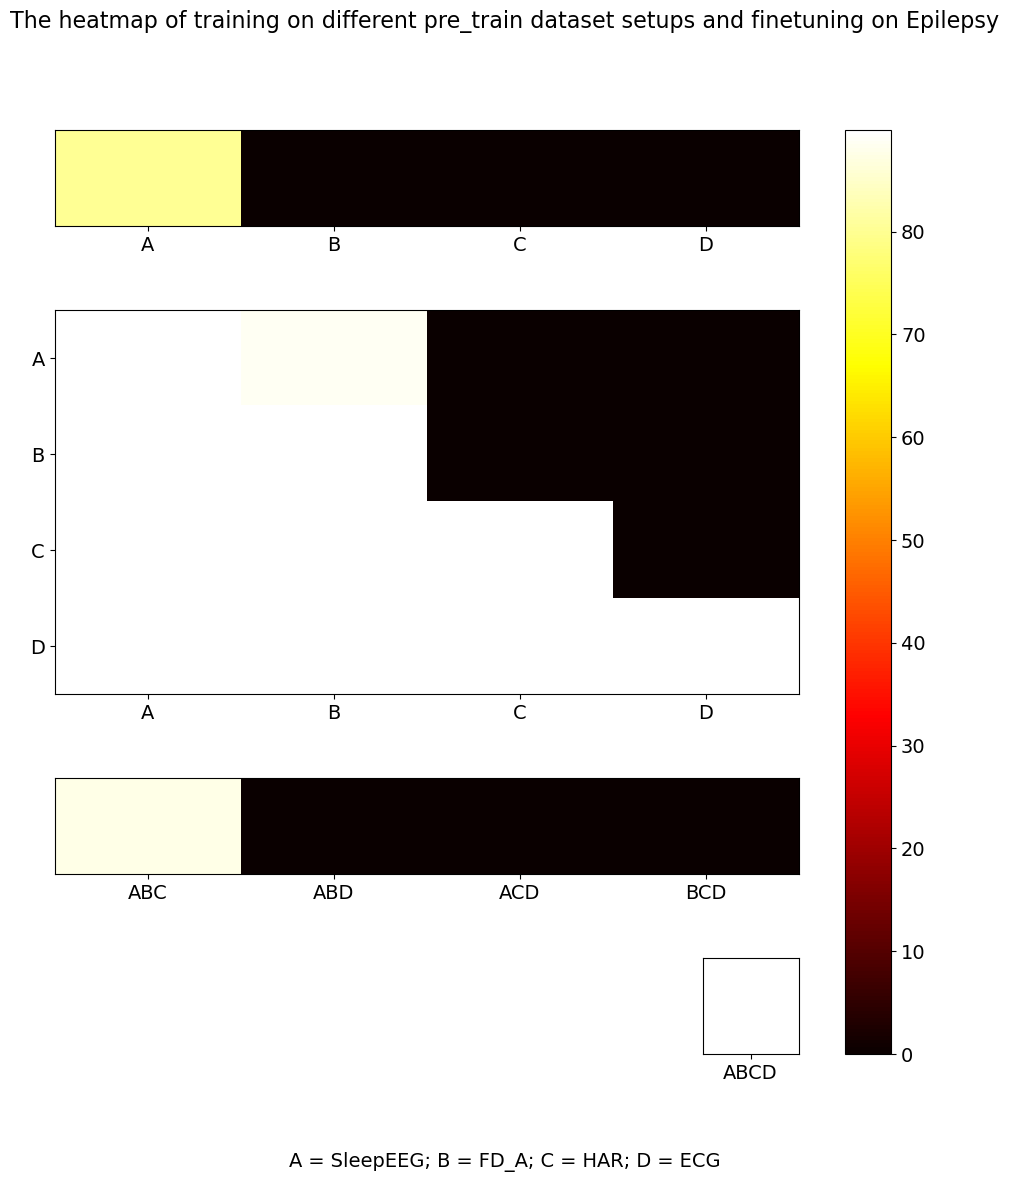

In [56]:
experiment()

# Embedding plot

In [46]:
import sys
import torch
import os
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

sys.path.append("/home/bbernard/TFC-pretraining/code/")
sys.path.append("/home/bbernard/TFC-pretraining/code/TFC")

from TFC.conv_model import *
from TFC.dataloader import data_generator

In [50]:
def get_model(configs, load_from, device, mode):

    TFC_model = TFC(configs).to(device)

    print("The loading file path", load_from)
    if mode == "pre_train":
        chkpoint = torch.load(os.path.join(load_from, "ckp_last.pt"), map_location=device)
    elif mode == "fine_tune_test":
        chkpoint = torch.load(os.path.join(load_from, "sleepedf2eplipsy_model.pt"), map_location=device)
    pretrained_dict = chkpoint["model_state_dict"]
    TFC_model.load_state_dict(pretrained_dict)
    
    return TFC_model

def get_configs(pretrain):
    print(pretrain)
    from config_files.SleepEEG_Configs import Config as Configs
    #exec(f'from config_files.{pretrain}_Configs import Config as Configs') #TODO change this, so it depends only on the fine_tune dataset
    configs = Configs()
    print(type(configs))

    return configs

def get_model_path(pretrain, target, run_description, mode, seed):
    logs_save_dir = "code/experiments_logs"
    experiment_description = str(pretrain) + '_2_' + str(target) + "_conv"

    experiment_log_dir = os.path.join(logs_save_dir, experiment_description, run_description, mode + f"_seed_{seed}_2layertransformer")

    if mode == "pre_train":
        experiment_log_dir = os.path.join(experiment_log_dir, "saved_models")
    elif mode == "fine_tune_test":
        experiment_log_dir = os.path.join(experiment_log_dir, "finetunemodel")
    
    return experiment_log_dir

def get_PCA(X_train, n_components = 2):

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    pca = PCA(n_components = n_components)
    X_train = pca.fit_transform(X_train)

    return X_train

def get_t_SNE(X_train):
    pass

def plot_embeddings(X_train, labels):
    # Predicting the training set
    # result through scatter plot 

    X_set, y_set = X_train, labels
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                        stop = X_set[:, 0].max() + 1, step = 0.01),
                        np.arange(start = X_set[:, 1].min() - 1,
                        stop = X_set[:, 1].max() + 1, step = 0.01))

    # plt.contourf(X1, X2, alpha = 0.75,
    #            cmap = ListedColormap(('green', 'blue')))

    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    color = ListedColormap(('green', 'blue'))(i), label = j)

    plt.title('Logistic Regression (Training set)')
    plt.xlabel('PC1') # for Xlabel
    plt.ylabel('PC2') # for Ylabel
    plt.legend() # to show legend

    # show scatter plot
    plt.show()

def plot_model_embeddings(pretrain, target, mode, run_description, subset, mixup, seed, device):
    
    # Get the configs, path and model running
    configs = get_configs(pretrain[0])
    load_from = get_model_path(pretrain, target, run_description, mode, seed)
    TFC_model = get_model(configs, load_from, device, mode)

    # Load the data
    sourcedata_path = [f"datasets/{pre}" for pre in pretrain]
    targetdata_path = f"datasets/{target}"

    _, _, test_dl = data_generator(sourcedata_path, targetdata_path, configs, mode, subset = subset, use_mixup = mixup)

    # Get the representation of each sample
    orig_representations = []
    orig_labels = []

    with torch.no_grad():
        for data, labels, aug1, data_f, aug1_f in test_dl:

            data = data.float().to(device)
            data_f = data_f.float().to(device)
            aug1 = aug1.float().to(device)
            aug1_f = aug1_f.float().to(device)

            _, z_t, _, _ = TFC_model(data, data_f)

            orig_representations.append(z_t)
            orig_labels.append(labels)

    orig_representations = torch.cat(orig_representations, dim = 0).cpu()
    orig_labels = torch.cat(orig_labels, dim = 0)

    # Do the PCA or t_SNE
    X_train = get_PCA(orig_representations, 2)
    print(X_train.shape)
    # Plot the results
    plot_embeddings(X_train, orig_labels)



In [51]:
with_gpu = torch.cuda.is_available()
if with_gpu:
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")
# # ##### fix random seeds for reproducibility ########
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
#####################################################

SleepEEG
<class 'config_files.SleepEEG_Configs.Config'>
model stride 8
model kernel size 8
The loading file path code/experiments_logs/['SleepEEG']_2_Epilepsy_conv/run1/pre_train_seed_42_2layertransformer/saved_models
The order of the datsets: ['datasets/SleepEEG']
(60, 2)


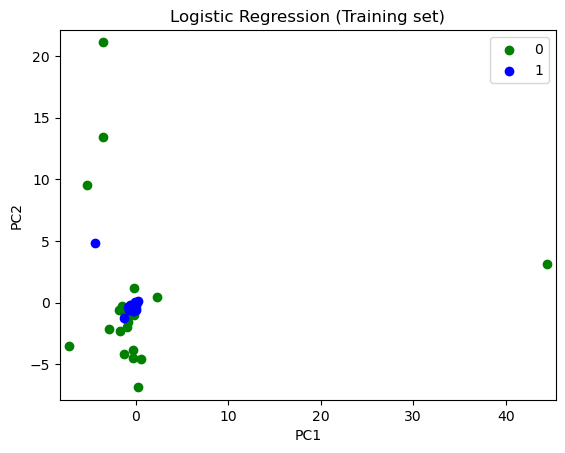

In [52]:
# Direction to saved models
logs_save_dir = "code/experiments_logs"

# Training parameters
pretrain_dataset = ["SleepEEG"]
targetdata = "Epilepsy"
run_description = "run1"
training_mode = "pre_train"
seed = 42

subset = False
mixup = False

plot_model_embeddings(pretrain_dataset, targetdata, training_mode, run_description, subset, mixup, seed, device)